# Tarea 1: búsqueda por similitud
**Integrantes:** 

Sebastián Alday
                 
Álvaro Neira

**Profesor de Cátedra:** José M. Saavedra.

**Profesor Auxiliar:** Cristóbal Loyola (cloyola@dcc.uchile.cl)

Se realizará búsqueda por similitud en un dataset de sketches de animales.

En este tutorial estudiaremos cómo realizar búsquedas por similitud. Para esto, utilizaremos el dataset QuickSketch-Animals, que contiene un total de 14.399 imágenes (12.000 de entrenamiento y 2.399 de test) de sketches, distribuidos en 11 clases.

El primer paso será entrenar dos modelos de clasificación sobre los datos: un modelo AlexNet y un modelo ResNet. Para esto, seguimos el mismo procedimiento de las clases prácticas anteriores.

In [ ]:
# Clonamos el repositorio
!git clone https://github.com/jmsaavedrar/convnet2.git

Cloning into 'convnet2'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 279 (delta 177), reused 161 (delta 84), pack-reused 0
Receiving objects: 100% (279/279), 77.21 KiB | 1.21 MiB/s, done.
Resolving deltas: 100% (177/177), done.


In [ ]:
!pwd  # muestra el directorio actual
!ls   # muestra el contenido de este (archivos y directorios)

/content
convnet2  sample_data


## Preparación de los datos

In [ ]:
# Crear directorios para datos y snapshots
!mkdir /content/convnet2/snapshots
!mkdir /content/convnet2/logs
!mkdir /content/convnet2/data

!ls convnet2

configs   models	      ssearch.py	     train_siamese.py
data	  README.md	      ssearch_with_merge.py  train_simple.py
datasets  release_siamese.py  test_tfrecords.py      utils
logs	  snapshots	      train.py


In [ ]:
# Descargar y descomprimir los datos
%cd /content/convnet2/data
!wget https://www.dropbox.com/sh/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa -O data.zip
!unzip -q data.zip
!unzip -q train_images.zip
!unzip -q test_images.zip
!rm data.zip
!rm train_images.zip
!rm test_images.zip
!ls

/content/convnet2/data
--2021-11-13 14:14:08--  https://www.dropbox.com/sh/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa [following]
--2021-11-13 14:14:08--  https://www.dropbox.com/sh/raw/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5a6b9b8d50ef55eeb9710217c1.dl.dropboxusercontent.com/zip_download_get/A9QkpV9gKPvBptQTHsxI2aoCIPxDlyYw649mce2o1jczKoGOFr0wzw9jTZsiQStUYAE-HD6I9xNpqxxTWViEpzkK5aHNUwIUiX2ErEXHNyP0-g# [following]
--2021-11-13 14:14:09--  https://uc5a6b9b8d50ef55eeb9710217c1.dl.dropboxusercontent.com/zip_download_get/A9QkpV9gKPvBptQTHsxI2aoCIPxDlyYw649mce2o1jczKoGOFr0wzw9jTZs

In [ ]:
mapping_dict = {'sheep': 0, 'bear': 1, 'bee': 2, 'cat': 3, 'camel': 4, 'cow': 5, 
                'crab': 6, 'crocodile': 7, 'duck': 8, 'elephant': 9, 'dog': 10, 'giraffe': 11}

In [ ]:
# Generar archivos de train y test
import os
import pandas as pd

def generate_annotations(base_dir, datasettype='test'):
    filenames = []
    labels = []
    data_prefix = f"data/{datasettype}_images/"
    data_dir = os.path.join(base_dir, data_prefix)
    print(f"buscando en el directorio: {data_dir}")
    # r=root, d=directories, f = files
    for r, d, f in os.walk(data_dir):
        for file in f:
            category_name = r.split('/')[-1]
            file = f"{category_name}/{file}"
            filenames.append(os.path.join(data_prefix, file))
            labels.append(mapping_dict[category_name])
    print(f"total de imágenes: {len(filenames)}")

    df = pd.DataFrame()
    df['filename'] = filenames
    df['cat_id'] = labels
    df = df.sample(frac=1)

    df.to_csv(f"{datasettype}.txt", sep='\t', header=False, index=False)

In [ ]:
%cd /content/convnet2/data
generate_annotations("/content/convnet2/", 'test')
generate_annotations("/content/convnet2/", 'train')

!ls

/content/convnet2/data
buscando en el directorio: /content/convnet2/data/test_images/
total de imágenes: 2399
buscando en el directorio: /content/convnet2/data/train_images/
total de imágenes: 12000
mapping.txt  test_images  test.txt  train_images  train.txt


In [ ]:
# Visualizamos las primeras líneas de test.txt
!cat test.txt | more

data/test_images/sheep/258_00125086.jpg	0
data/test_images/camel/054_00120314.jpg	4
data/test_images/camel/054_00120365.jpg	4
data/test_images/sheep/258_00125054.jpg	0
data/test_images/crab/082_00125813.jpg	6
data/test_images/crab/082_00125795.jpg	6
data/test_images/crab/082_00125780.jpg	6
data/test_images/dog/091_00151044.jpg	10
data/test_images/crab/082_00125799.jpg	6
data/test_images/duck/099_00134437.jpg	8
data/test_images/crocodile/084_00126880.jpg	7
data/test_images/cow/081_00121916.jpg	5
data/test_images/dog/091_00150976.jpg	10
data/test_images/dog/091_00151118.jpg	10
data/test_images/dog/091_00150973.jpg	10
data/test_images/bee/026_00119823.jpg	2
data/test_images/camel/054_00120340.jpg	4
data/test_images/giraffe/129_00126033.jpg	11
data/test_images/cow/081_00122005.jpg	5
data/test_images/crab/082_00125835.jpg	6
data/test_images/cow/081_00121998.jpg	5
data/test_images/bee/026_00119850.jpg	2
data/test_images/bear/023_00133654.jpg	1
data/test_images/crab/082_00125896.jpg	6
data/te

In [ ]:
# Podemos ver el número de lineas de cada archivo
%cd /content/convnet2/data
!wc -l "test.txt"
!wc -l "train.txt"


/content/convnet2/data
2399 test.txt
12000 train.txt


## Generación de TFRecords

Al igual que en la clase anterior, convertiremos los datos a un formato binario que TensorFlow puede manejar de manera eficiente (más información sobre tfrecords [aquí](https://www.tensorflow.org/tutorials/load_data/tfrecord)). Para esto, haremos las siguientes modificaciones:

En el archivo ```/content/convnet2/configs/sketch.config```:

* [SKETCH]
* NUM_EPOCHS = 20
* NUM_CLASSES = 12
* BATCH_SIZE = 128
* VALIDATION_STEPS = 19
* LEARNING_RATE = 0.01
* DECAY_STEPS = 10000
* SNAPSHOT_DIR = /content/convnet2/snapshots
* DATA_DIR = /content/convnet2/data
* CHANNELS = 3
* IMAGE_TYPE = SKETCH
* IMAGE_WIDTH = 224
* IMAGE_HEIGHT = 224
* USE_MULTITHREADS = False
* CKPFILE = /content/convnet2/snapshots/alexnet_020.h5


In [ ]:
# Creamos los tfrecords
%cd /content/convnet2
!python datasets/create_tfrecords.py -type all -config configs/sketch.config -name SKETCH
!ls data

/content/convnet2
---0
---500
---1000
---1500
---2000
---2500
---3000
---3500
---4000
---4500
---5000
---5500
---6000
---6500
---7000
---7500
---8000
---8500
---9000
---9500
---10000
---10500
---11000
---11500
---11999
train_record saved at /content/convnet2/data/train.tfrecords.
mean_file (224, 224, 3)
mean_file saved at /content/convnet2/data/mean.dat.
shape_file saved at /content/convnet2/data/shape.dat.
---0
---500
---1000
---1500
---2000
---2398
test_record saved at /content/convnet2/data/test.tfrecords.
tfrecords created for /content/convnet2/data
mapping.txt  shape.dat	  test.tfrecords  train_images	   train.txt
mean.dat     test_images  test.txt	  train.tfrecords


In [ ]:
!ls /content/convnet2/data

mapping.txt  shape.dat	  test.tfrecords  train_images	   train.txt
mean.dat     test_images  test.txt	  train.tfrecords


## Entrenamiento

A continuación, entrenaremos los modelos AlexNet y ResNet con los datos recién generados.

### AlexNet

En el archivo ```/content/convnet2/train_simple.py``` cambiamos lo siguiente:

* En la línea 78, cambiamos el condicional por:

```
if configuration.get_model_name() in ['SKETCH', 'SBIR']:
```
Ocupé solamente la configuración 'SKETCH', entonces no se cambia esta línea.


In [ ]:
# Entrenamos AlexNet
%cd /content/convnet2
!python train_simple.py -mode train -config configs/sketch.config -name SKETCH

/content/convnet2
2021-11-12 18:48:48.038242: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "alex_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  34944     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 384       
 ormalization)                                                   
              

### ResNet-34

En el archivo ```/content/convnet2/train_simple.py```:

* Agregamos ```from models import resnet``` al comienzo del archivo.

* Descomentamos la línea 86: model = resnet.ResNet(...) cambiando el valor de use_bottleneck por False.

In [ ]:
%cd /content/convnet2
!rm -r snapshots/*
!python train_simple.py -mode train -config configs/sbir_cl.config -name SBIR

/content/convnet2
2021-10-20 20:03:57.676769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 20:03:57.688680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 20:03:57.689497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 20:03:57.690938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 20:03:57.691748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUM

### ResNet-34 con fine-tuning

A continuación, volveremos a entrenar un modelo ResNet-34 pero comenzando con pesos pre-entrenados en ImageNet. Notemos que en este caso el dominio de ambos problemas es distinto (sketches versus imágenes).

In [ ]:
# Descargamos los pesos pre-entrenados
%cd /content/convnet2/snapshots
!rm *.h5
!wget https://www.dropbox.com/s/ea61crvnckf96ez/imagenet_045.h5 

/content/convnet2/snapshots
rm: cannot remove '*.h5': No such file or directory
--2021-10-21 16:08:41--  https://www.dropbox.com/s/ea61crvnckf96ez/imagenet_045.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ea61crvnckf96ez/imagenet_045.h5 [following]
--2021-10-21 16:08:41--  https://www.dropbox.com/s/raw/ea61crvnckf96ez/imagenet_045.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc85288e587648801c4d851c1ee0.dl.dropboxusercontent.com/cd/0/inline/BYf7y21Itn9U5ei6rSW6FelndPthJLvdLU2e0iSe1FGYOt5jVz4ft-UCd-fAfWIo3VmJK0d8iVzEvcDdRS7JGjmQBiM15ysEO9Zxu7E1Il_gfkVlVi08Cj3Mb5vz68x8uzHIlXvAjesiGJWLVXo43302/file# [following]
--2021-10-21 16:08:41--  https://uc85288e587648801c4d851c1ee0.dl.dropboxusercontent.com/cd/0/inline/B

En el archivo ```/content/convnet2/configs/sbir_cl.config```, agregamos la línea:

```
CKPFILE = /content/convnet2/snapshots/imagenet_045.h5
```

Ahora el entrenamiento comenzará con esos pesos. 

In [ ]:
%cd /content/convnet2
!python train_simple.py -mode train -config configs/sbir_cl.config -name SBIR

/content/convnet2
2021-10-20 21:03:53.558977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 21:03:53.567580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 21:03:53.568376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 21:03:53.569815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 21:03:53.570653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUM

Podemos ver que al utilizar pesos pre-entrenados en ImageNet, con unas pocas épocas de entrenamiento se obtienen mejores resultados (74% de accuracy en validación) que en los casos anteriores: 55% con AlexNet y 61% con Resnet sin fine-tuning).

Luego de entrenar un modelo, es importante guardar los pesos obtenidos (por ejemplo, el checkpoint de la última época). Si no hacemos esto, perderemos los checkpoints una vez que cerremos sesión en Colab.

## Predicciones

A continuación, veremos algunas predicciones de ejemplo utilizando los pesos aprendidos por este último modelo. Para esto, copiaremos el último checkpoint desde Google Drive a la sesión de Colab (si no se ha cerrado la sesión desde el entrenamiento, este paso no será necesario). Podemos acceder al contenido de nuestro Drive con el botón "Activar unidad de Drive" en el menú de la izquierda.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/convnet2/
!cp /content/drive/MyDrive/alexnet_020.h5 snapshots

/content/convnet2


Para utilizar este checkpoint, agregamos en el archivo ```/content/convnet2/configs/sbir_cl.config``` la siguiente línea (cambiar por el nombre de archivo correcto):

* CKPFILE = /content/convnet2/snapshots/resnet34_pretrained_011.h5

Finalmente, en el archivo ```/content/convnet2/train_simple.py```:

* agregamos ```from models import resnet``` al inicio.
* descomentamos la línea 86 y cambiamos el valor de use_bottleneck por False.

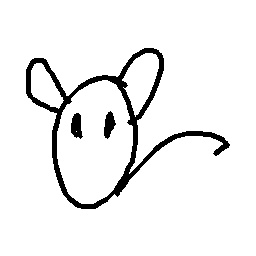

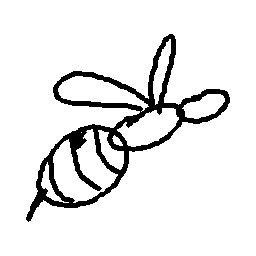

In [ ]:
from IPython.display import Image, display

display(Image('/content/convnet2/data/test_images/bear/023_00133562.jpg', width=200, height=200))
display(Image('/content/convnet2/data/train_images/bee/026_00119890.jpg', width=200, height=200))
#display(Image('/content/convnet2/data/Sketch_EITZ/png_w256/crocodile/5006.png', width=200, height=200))

In [ ]:
%cd /content/convnet2
!python train_simple.py -mode predict -config configs/sketch.config -name SKETCH

/content/convnet2
2021-11-13 14:30:46.169234: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "alex_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  34944     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 384       
 ormalization)                                                   
              

Para los ejemplos anteriores, el modelo predice las clases '4', '6', '9' y '11', que corresponden a 'camel', 'crab', 'elephant' y 'giraffe' según el archivo mapping.txt. Las predicciones son correctas y tienen una alta probabilidad, en general.

## Búsqueda por similitud

Finalmente, usaremos la salida de la última capa fully-connected de AlexNet para realizar una búsqueda por similitud. Utilizaremos el archivo ```/content/convnet2/ssearch.py```. El primer paso es preparar un directorio y un catálogo:

In [ ]:
%cd /content/convnet2/data

# Crear directorio para la búsqueda por similitud
!mkdir ssearch

# Eliminar la columna de clasificación del archivo test.txt
!awk 'NF{NF-=1};1' <test.txt >catalog.txt
!mv catalog.txt ssearch/

/content/convnet2/data


### AlexNet (ResNet-34) entrenada con sketches

Haremos una búsqueda por similitud utilizando la distancia coseno entre vectores. 

En el archivo ```/content/convnet2/models/alexnet.py```: 

* En el método call de la clase AlexNetModel (línea 37), cambiamos el return a la línea que sigue inmediatamente a x = self.relu(x) de la capa 7 (fc7). De esta forma, la salida del modelo será directamente la capa que necesitamos.

En el archivo ```/content/convnet2/ssearch.py```:

* Reemplazamos las líneas 26 a la 40 por:
```
#loading classifier model
        model = alexnet.AlexNetModel(self.configuration.get_number_of_classes())
        input_image = tf.keras.Input((self.input_shape[0], self.input_shape[1], self.input_shape[2]), name = 'input_image')     
        model(input_image)    
        model.summary()
        model.load_weights(self.configuration.get_checkpoint_file(), by_name = True, skip_mismatch = True)
        self.sim_model = model
        print('sim_model was loaded OK')
        # defining process arch
        self.process_fun = imgproc.process_sketch
```

* En el método search: descomentamos las líneas sim = ... y definimos ```idx_sorted = np.argsort(-sim)```. Esto si queremos utilizar la distancia coseno. En nuestro caso utilizamos la distancia euclidiana.



In [ ]:
# Calculamos los feature vectors
%cd /content/convnet2/
!python ssearch.py -config configs/sketch.config -name SKETCH -mode compute

/content/convnet2
2021-11-13 14:40:33.525083: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "alex_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  34944     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 384       
 ormalization)                                                   
              

In [ ]:
# Hacemos la búsqueda por similitud 
!python ssearch.py -config configs/sketch.config -name SKETCH -mode search

2021-11-12 20:54:11.976603: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "alex_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  34944     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 384       
 ormalization)                                                   
                                

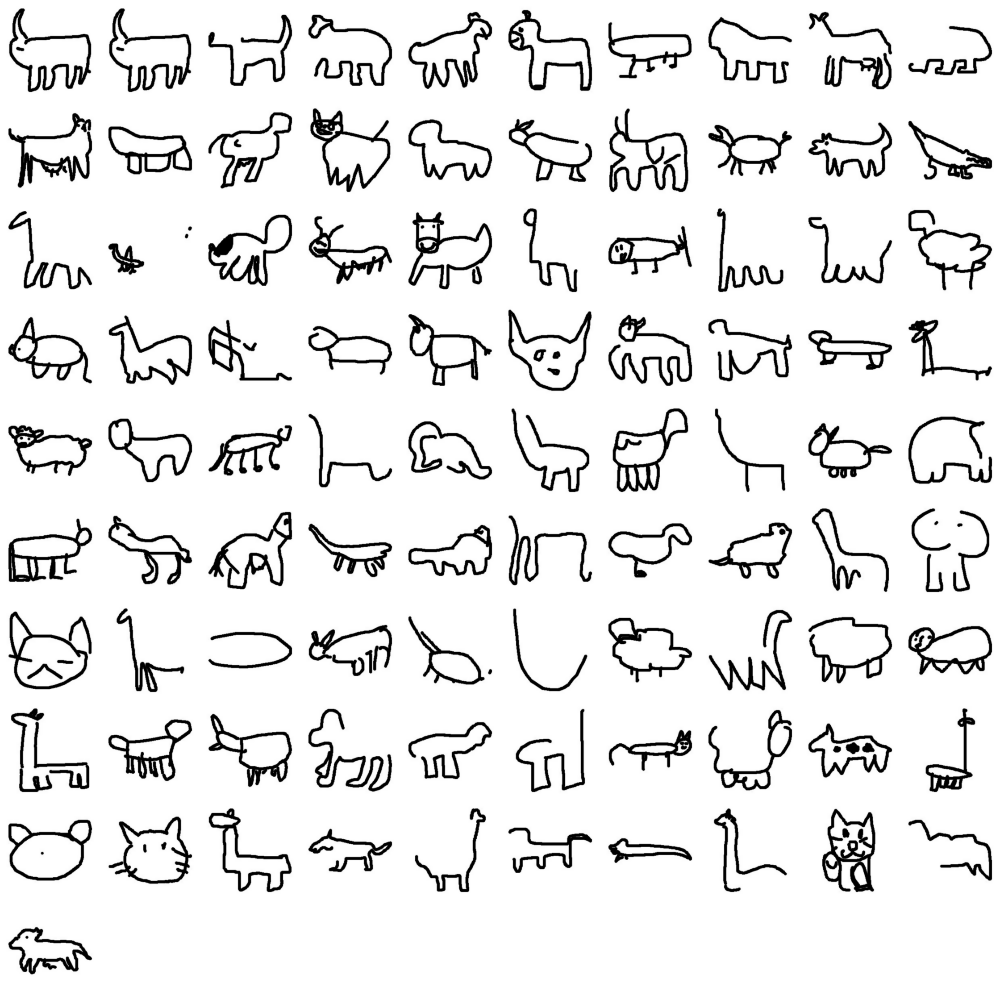

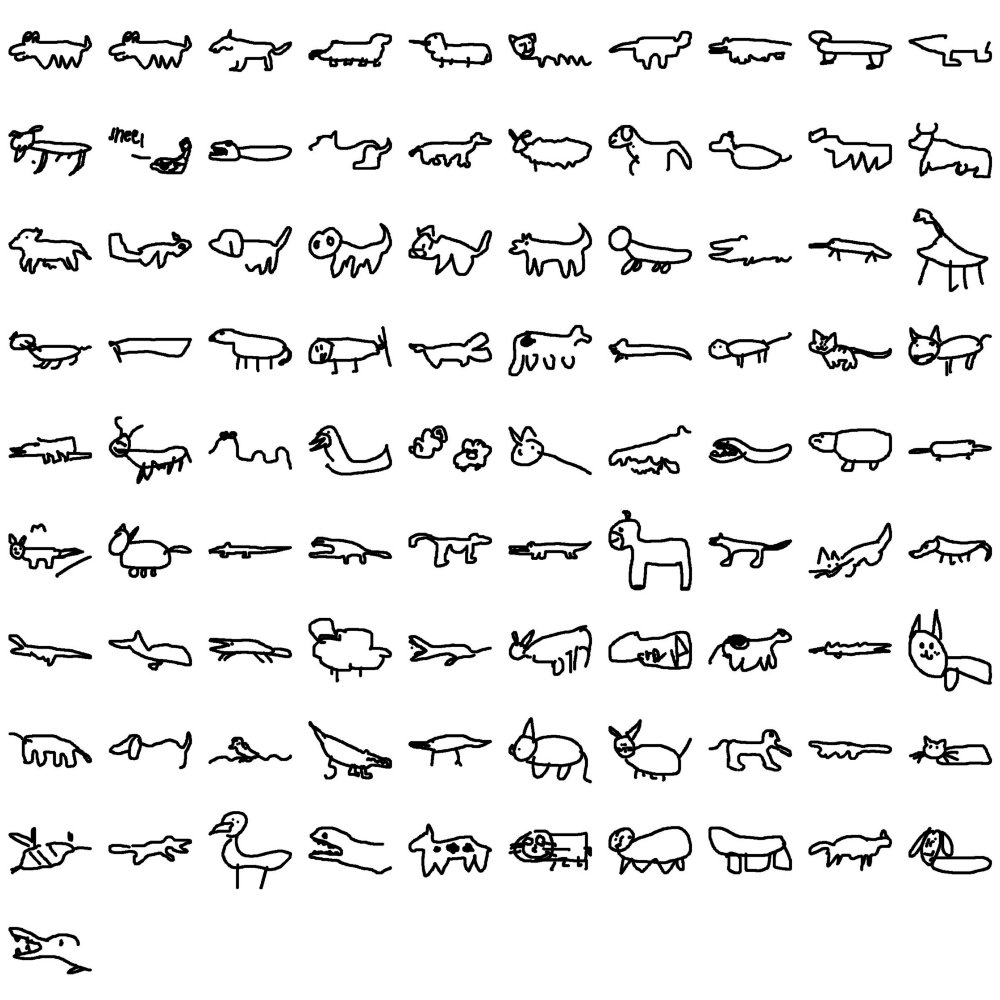

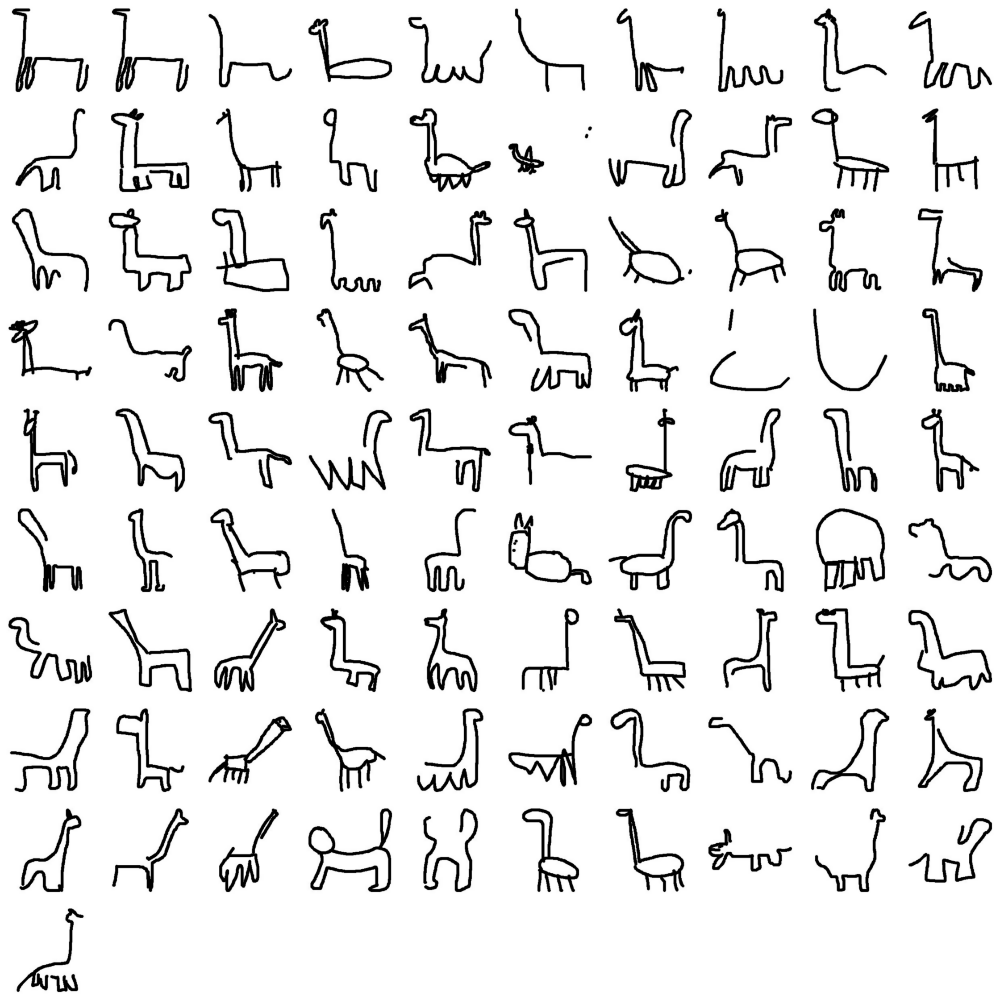

In [ ]:
from IPython.display import Image, display
display(Image('/content/convnet2/081_00121885.jpg_result.png', width=700, height=700))
display(Image('/content/convnet2/091_00150965.jpg_result.png', width=700, height=700))
display(Image('/content/convnet2/129_00125998.jpg_result.png', width=700, height=700))

Para obtener las métricas a evaluar (y utilizar la técnica leave-one-out) se comenta el return de la función search y se cambia por: 
```
return idx_sorted[1:]
```



In [ ]:
lista_ejemplo = ['/content/convnet2/data/test_images/cow/081_00121885.jpg',
                 '/content/convnet2/data/test_images/dog/091_00150965.jpg']

In [ ]:
# Hacemos la búsqueda por similitud en toda la lista de archivos
# Distancia euclidiana
%cd /content/convnet2/
!python ssearch.py -config configs/sketch.config -name SKETCH -mode search -list data/ssearch/catalog.txt

/content/convnet2
2021-11-13 18:50:11.857817: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "alex_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  34944     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 384       
 ormalization)                                                   
              

In [ ]:
# Hacemos la búsqueda por similitud en toda la lista de archivos
# Distancia coseno
%cd /content/convnet2/
!python ssearch.py -config configs/sketch.config -name SKETCH -mode search -list data/ssearch/catalog.txt

/content/convnet2
2021-11-13 19:10:45.017077: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "alex_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  34944     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 384       
 ormalization)                                                   
              

In [ ]:
with open('data/ssearch/catalog.txt') as f_list :
  filenames  = [ item.strip() for item in f_list]

In [ ]:
filenames[:2]

['data/test_images/dog/091_00151020.jpg',
 'data/test_images/dog/091_00150981.jpg']

In [ ]:
mapping_dict = {'sheep': 0, 'bear': 1, 'bee': 2, 'cat': 3, 'camel': 4, 'cow': 5, 
                'crab': 6, 'crocodile': 7, 'duck': 8, 'elephant': 9, 'dog': 10, 'giraffe': 11}
for animal in mapping_dict:
  print(mapping_dict[animal], animal)              

0 sheep
1 bear
2 bee
3 cat
4 camel
5 cow
6 crab
7 crocodile
8 duck
9 elephant
10 dog
11 giraffe


In [ ]:
import numpy as np
import math
lista = [*range(0,101,10)]

lista = [i/100 for i in lista]
lista = [math.floor(i*135) for i in lista]
lista

[0, 13, 27, 40, 54, 67, 81, 94, 108, 121, 135]

In [ ]:
precision_recall = [0]*11
precision_recall

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Text(0.5, 1.0, 'AlexNet Distancia Euclidiana')

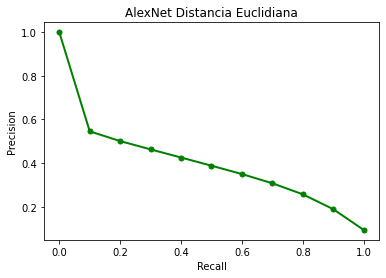

In [ ]:
import matplotlib.pyplot as plt
# Distancia euclidiana
precision = [1, 0.5456095583567377, 0.5010608390731737, 0.4629729748952049, 0.42567121936099234, 0.38827407834045585, 0.34984568674813404, 0.3077455144911413, 0.25707778758533534, 0.1890278549756104, 0.09380918283201867]
recall = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plt.plot(recall, precision, color='green', marker='o', 
         linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AlexNet Distancia Euclidiana')

Text(0.5, 1.0, 'AlexNet Distancia Coseno')

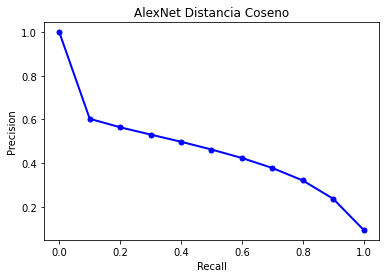

In [ ]:
import matplotlib.pyplot as plt
# Distancia coseno
precision = [1, 0.6030622978044692, 0.5640527647876532, 0.5307108337177999, 0.4977641365086941, 0.4621900495441424, 0.4233040769266742, 0.3774300589554854, 0.32009831639997344, 0.23607410770646797, 0.09336547474134026]
recall = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plt.plot(recall, precision, color='blue', marker='o', 
         linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AlexNet Distancia Coseno')